In [2]:
from dynmodes import *
from matplotlib import pyplot as plt
import xarray as xr
from tqdm import tqdm as progressbar

In [3]:
def density_profile(depth):
    """Return a density profile as described in eq 50 of McCreary (1980)."""
    rho_0 = 1.028
    d_rho_1 = 0.003
    d_rho_2 = 0.002
    b_1 = 200.
    b_2 = 1000.
    H = 75.
    rho = rho_0 + d_rho_1 * (1 - np.exp(-(depth - H) / b_1)) + d_rho_2 * (1 - np.exp(-(depth - H) / b_2))
    rho[np.where(depth < 75.)] = rho_0
    return rho

In [4]:
depth = np.linspace(0, 1500, 151)
rho = density_profile(depth)

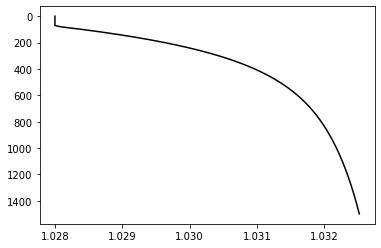

In [5]:
fig, ax = plt.subplots()
ax.plot(rho, depth, color = 'black')
ax.invert_yaxis()

In [6]:
Nsq_depth, Nsq = density2Nsq(depth, rho)
Nsq[Nsq==0] = 1e-9

In [7]:
(wmodes, pmodes, ce) = dynmodes(Nsq, Nsq_depth, 16)

In [8]:
ds_pmodes =xr.DataArray(pmodes, dims=['nmode','depth'])
ds_modes = ds_pmodes.to_dataset(name='pmodes')
ds_modes['ce'] = ('nmode',ce)
ds_modes.coords['nmode'] = np.arange(pmodes.shape[0])
ds_modes.coords['depth'] = Nsq_depth[1:]

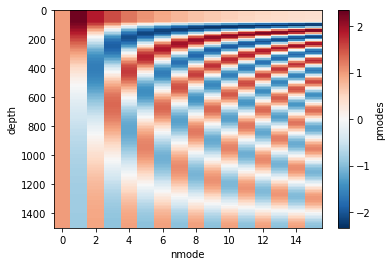

In [9]:
ds_modes.pmodes.plot(x='nmode', y='depth', yincrease=False)

In [10]:
A = np.amax(Nsq) * 0.55
H_n = ds_modes.ce.values**2 / 9.81
gamma = A / ds_modes.ce.values**2

In [15]:
def tau(x, y):
    """"Wind field according to Mccreary (1980)."""
    delta_x = abs(x[0, 0] - x[0, -1]) / 2
    delta_y = abs(y[0, 0] - y[-1, 0]) / 2

    wind_x = np.cos(np.pi * x / delta_x)
    wind_x[abs(x) > delta_x / 2] = 0

    wind_y = (1 + y**2 / delta_y**2) * np.exp( - y**2 / delta_y**2)

    return -5e-6 * wind_x * wind_y

In [16]:
from  multimodemodel import StaggeredGrid

c_grid = StaggeredGrid.regular_lat_lon_c_grid(
    lon_start=-50.0,
    lon_end=50.0,
    lat_start=-5.0,
    lat_end=5.0,
    nx=100 * 4 + 1,
    ny=10 * 4 + 1,
    z = np.array([0])
)

In [17]:
from multimodemodel import Parameters, f_on_sphere
params = []
for i in range(len(H_n)):
    params.append(
        Parameters(
            coriolis_func=f_on_sphere(omega=7.272205e-05),
            on_grid=c_grid,
            H=np.array([H_n[i]]),
            gamma = np.array([gamma[i]]),
        )
    )

In [18]:
from multimodemodel import (
    State, Variable,
 )
tau_x = np.expand_dims(tau(c_grid.u.x, c_grid.u.y), axis=0)
def zonal_wind(state, params):
    return State(u=Variable(tau_x /  params.rho_0, c_grid.u, np.datetime64("NaT")))

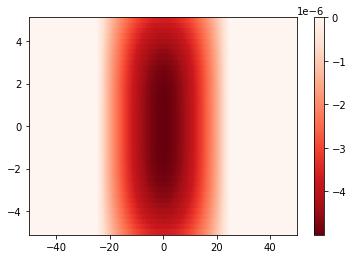

In [19]:
plt.figure()
plt.pcolormesh(c_grid.u.x, c_grid.u.y, tau_x[0], shading='auto', cmap='Reds_r')
plt.colorbar()

In [20]:
import functools as ft
import operator as op
from multimodemodel import (
    pressure_gradient_i, pressure_gradient_j,
    coriolis_i, coriolis_j,
    divergence_i, divergence_j,
    laplacian_mixing_u, laplacian_mixing_v,
    linear_damping_v, linear_damping_u,
    linear_damping_eta
)

terms = [
    pressure_gradient_i, pressure_gradient_j,
    coriolis_i, coriolis_j,
    divergence_i, divergence_j,
    laplacian_mixing_u, laplacian_mixing_v,
    linear_damping_v, linear_damping_u,
    linear_damping_eta, zonal_wind
]

def rhs(state, params):
    return ft.reduce(op.add, (term(state, params) for term in terms))

In [21]:
def save_as_Dataset(state: State, params: Parameters):
    w = (divergence_j(state, params) + divergence_i(state, params)).eta
    ds = state.variables["u"].as_dataarray.to_dataset(name='u_tilde')
    ds['v_tilde'] = state.variables["v"].as_dataarray
    ds['w_tilde'] = w.as_dataarray
    x = (["j", "i"], (state.u.grid.x + state.v.grid.x) / 2)
    y = (["j", "i"], (state.u.grid.y + state.v.grid.y) / 2)
    ds.assign_coords({"x": x, "y": y})
    return ds

In [22]:
from multimodemodel import integrate, adams_bashforth3

time = 30 * 24 * 3600.  # 1 year
step_barotropic = c_grid.u.dx.min() / ds_modes.ce.values.max() / 4.  # applying CFL criterion with some safety net
step_baroclinic = round((c_grid.u.dx.min() / ds_modes.ce.values[1:].max() / 1000) / step_barotropic) * step_barotropic
t0 = np.datetime64("2000-01-01")

In [23]:
ds_modes.ce.values[1:].max()

0.076604537484788

In [24]:
def run_barotropic(params):
    init_state = State(
            u=Variable(None, c_grid.u, t0),
            v=Variable(None, c_grid.v, t0),
            eta=Variable(None, c_grid.eta, t0),
            q=Variable(None, c_grid.q, t0)
        )
    model_run = integrate(
        init_state,
        params,
        RHS=rhs,
        scheme=adams_bashforth3,
        step=step_barotropic,
        time=time,
    )
    
    Nt = time // step_barotropic

    output = []

    for i, next_state in enumerate(progressbar(model_run)):
        if i % (Nt // 5) == 0:
            output.append(save_as_Dataset(next_state, params))
            #convergence.append((output[-1].u_tilde.values - output[-2].u_tilde.values).nanmax())
    
    return xr.combine_by_coords(output)

In [25]:
def run_baroclinic(params):
    model_run = integrate(
        State(
            u=Variable(None, c_grid.u, t0),
            v=Variable(None, c_grid.v, t0),
            eta=Variable(None, c_grid.eta, t0),
            q=Variable(None, c_grid.q, t0)
        ),
        params,
        RHS=rhs,
        scheme=adams_bashforth3,
        step=step_baroclinic,
        time=time,
    )
    
    Nt = time // step_baroclinic

    output = []

    for i, next_state in enumerate(model_run):
        if i % (Nt // 5) == 0:
            output.append(save_as_Dataset(next_state, params))
    
    
    return xr.combine_by_coords(output)

In [26]:
from multiprocessing import Pool

pool = Pool()
out_baroclinic = pool.map(run_baroclinic, params[1:])

/home/david/Uni/Thesis/multimode-model/multimodemodel/datastructure.py:207: RuntimeWarning: invalid value encountered in add
  new_data = self.data + other.data
/home/david/Uni/Thesis/multimode-model/multimodemodel/datastructure.py:207: RuntimeWarning: invalid value encountered in add
  new_data = self.data + other.data
/home/david/Uni/Thesis/multimode-model/multimodemodel/datastructure.py:207: RuntimeWarning: invalid value encountered in add
  new_data = self.data + other.data
/home/david/Uni/Thesis/multimode-model/multimodemodel/datastructure.py:207: RuntimeWarning: invalid value encountered in add
  new_data = self.data + other.data
/home/david/Uni/Thesis/multimode-model/multimodemodel/datastructure.py:207: RuntimeWarning: invalid value encountered in add
  new_data = self.data + other.data


In [106]:
out = [out_barotropic] + out_baroclinic

In [27]:
for i in range(len(out_baroclinic)):
    out_baroclinic[i]["z"] = np.array([i])
velocities = xr.combine_by_coords(out_baroclinic)

In [28]:
ds_pmodes =xr.DataArray(pmodes, dims=['z','depth'])
ds_pmodes.coords['z'] = np.arange(pmodes.shape[0])
ds_pmodes.coords['depth'] = Nsq_depth[1:]

In [29]:
ds_wmodes =xr.DataArray(wmodes, dims=['z','depth'])
ds_wmodes.coords['z'] = np.arange(wmodes.shape[0])
ds_wmodes.coords['depth'] = Nsq_depth

In [30]:
velocities['u'] = xr.dot(ds_pmodes, velocities.u_tilde)
velocities['v'] = xr.dot(ds_pmodes, velocities.v_tilde)
velocities['w'] = xr.dot(ds_wmodes, velocities.w_tilde)

Text(0.5, 1.02, 'u [m/s] at x = 0')

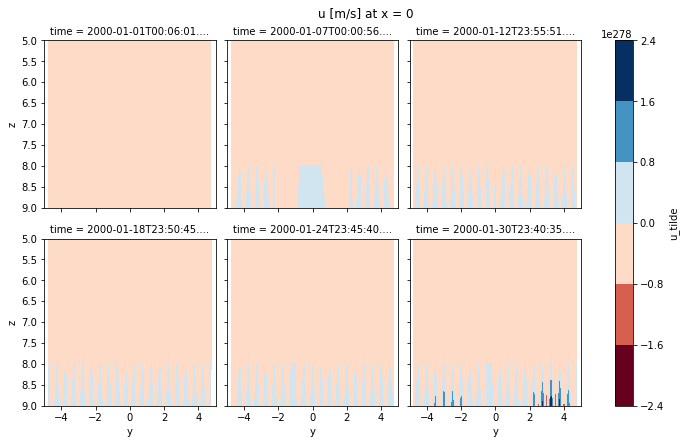

In [40]:
velocities.u_tilde.isel(i = 200, z = slice(5, 10)).plot.contourf(x='y', y='z', col="time", col_wrap=3, cmap='RdBu', yincrease=False);
plt.suptitle('u [m/s] at x = 0', y=1.02)

Text(0.5, 1.02, 'v [m/s] at x = 0')

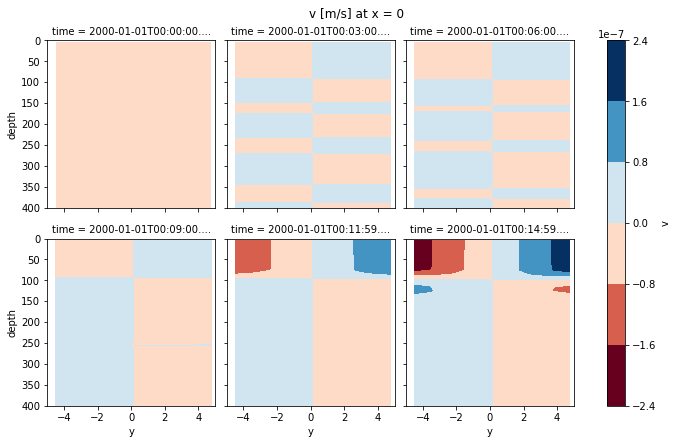

In [112]:
velocities.v.isel(i = 200).plot.contourf(x='y', y='depth', col="time", col_wrap=3, cmap='RdBu', yincrease=False, ylim = (400, 0));
plt.suptitle('v [m/s] at x = 0', y=1.02)

Text(0.5, 1.02, 'w [m/s] at x = 0')

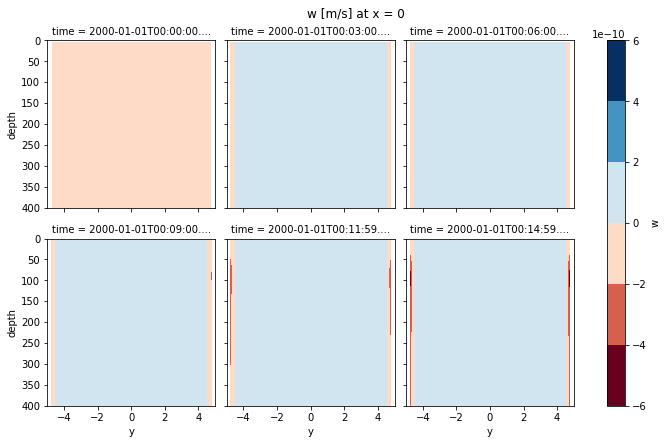

In [113]:
velocities.w.isel(i = 200).plot.contourf(x='y', y='depth', col="time", col_wrap=3, cmap='RdBu', yincrease=False, ylim = (400, 0));
plt.suptitle('w [m/s] at x = 0', y=1.02)

# McCreary Plots:

In [114]:
def lon_section_plot(ds: xr.Dataset, i: int):
    fig, axs = plt.subplots(1, 2, sharey=True, figsize=(20,10))
    ds.u.isel(i=i, time=-1).plot.contourf(x='y', y='depth', cmap='RdBu', yincrease=False, ylim = (400, 0), ax = axs[0])
    ds.isel(i=i, time=-1).plot.quiver(x='y', y='depth', u='v', v='w', ax = axs[1]);

Text(0.5, 0.98, 'Velocity structure along section 1 in McCreary')

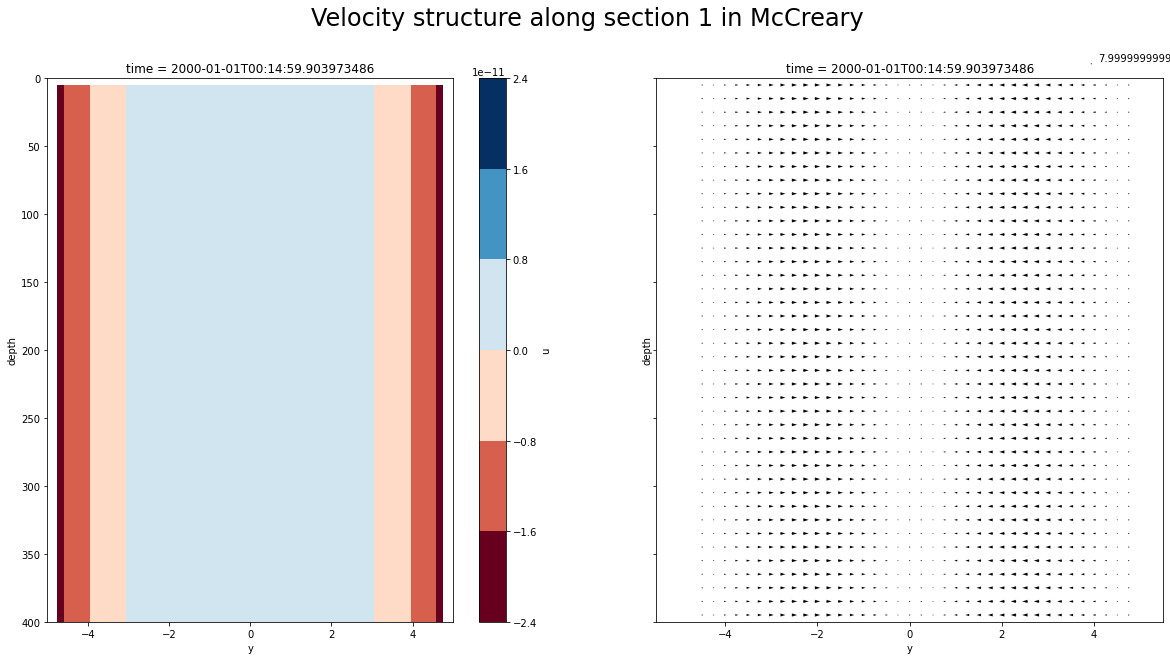

In [115]:
lon_section_plot(velocities, 40)
plt.suptitle('Velocity structure along section 1 in McCreary', fontsize=24)

Text(0.5, 0.98, 'Velocity structure along section 2 in McCreary')

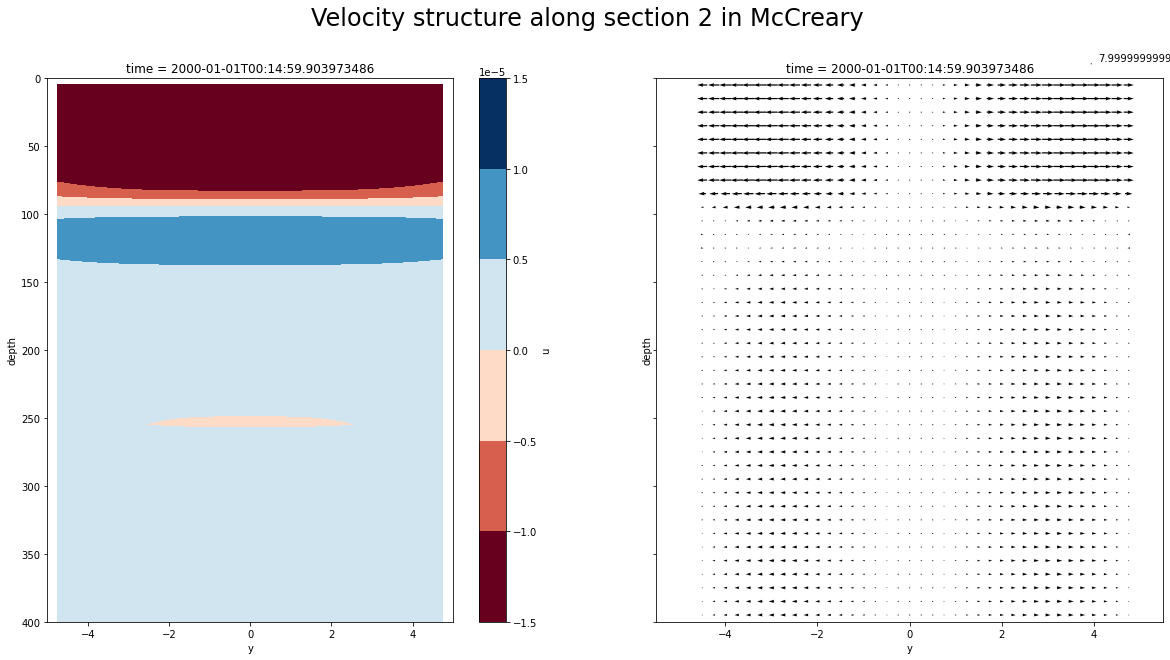

In [117]:
lon_section_plot(velocities, 120)
plt.suptitle('Velocity structure along section 2 in McCreary', fontsize=24)

Text(0.5, 0.98, 'Velocity structure along section 3 in McCreary')

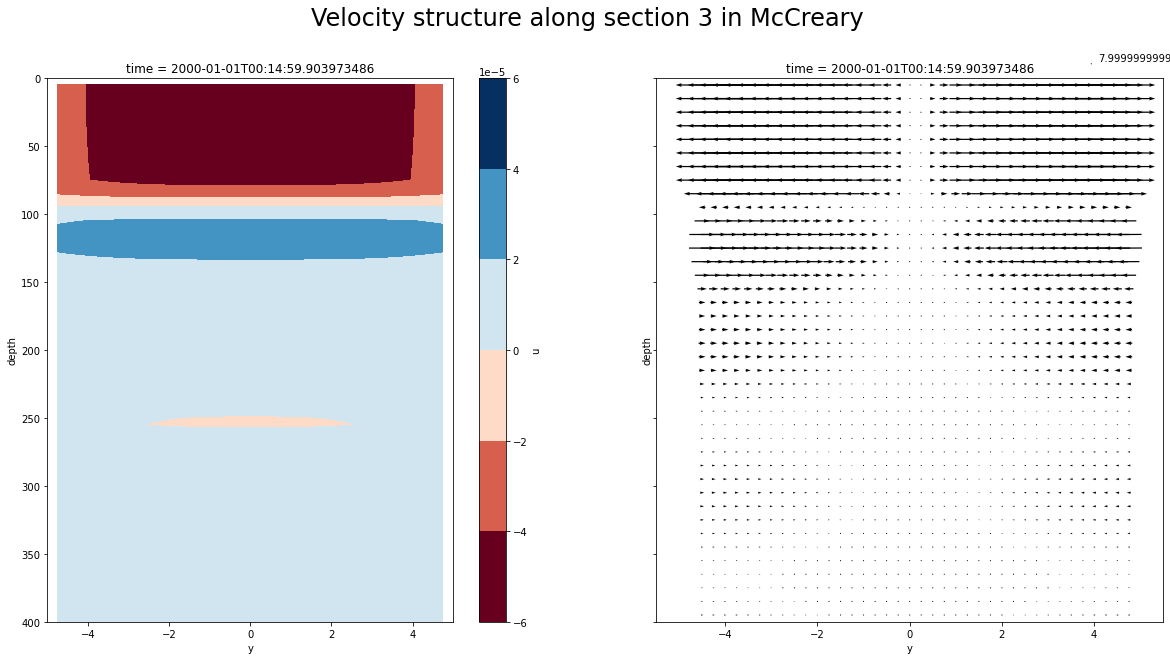

In [118]:
lon_section_plot(velocities, 200)
plt.suptitle('Velocity structure along section 3 in McCreary', fontsize=24)

Text(0.5, 0.98, 'Velocity structure along section 4 in McCreary')

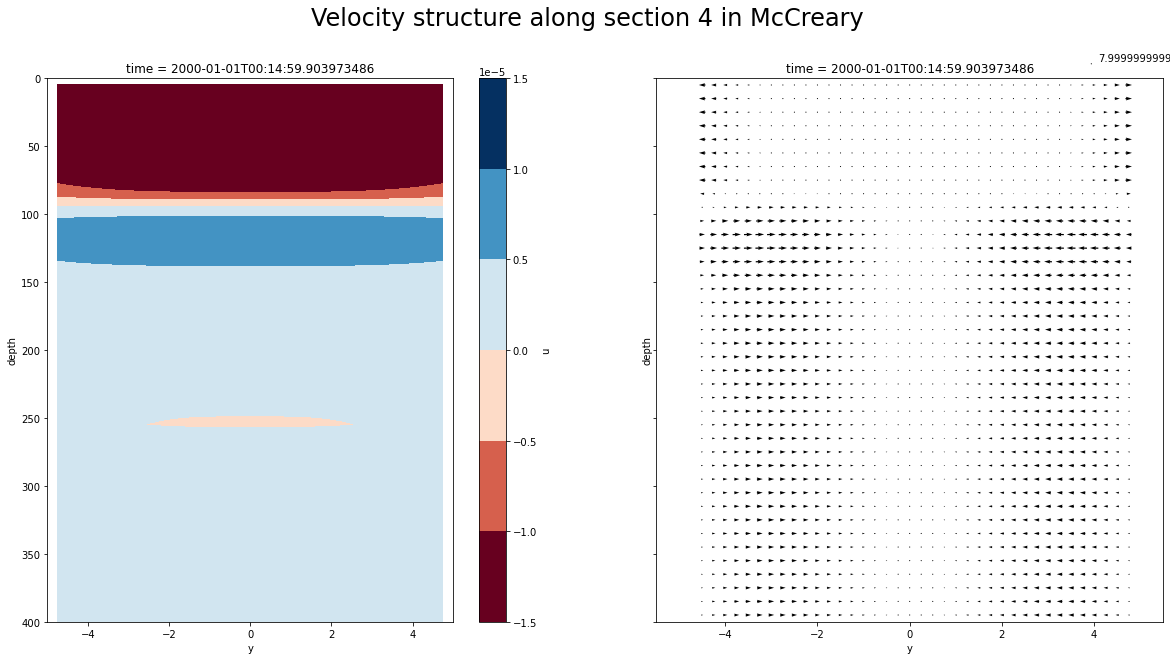

In [119]:
lon_section_plot(velocities, 280)
plt.suptitle('Velocity structure along section 4 in McCreary', fontsize=24)

Text(0.5, 0.98, 'Velocity structure along section 5 in McCreary')

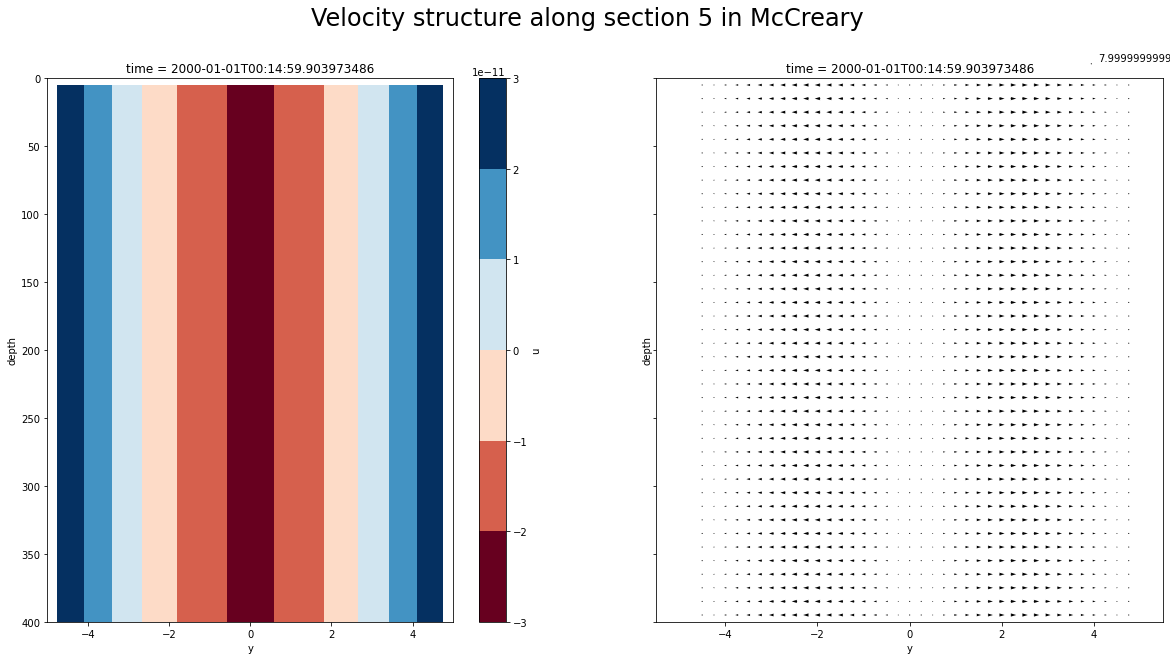

In [120]:
lon_section_plot(velocities, 360)
plt.suptitle('Velocity structure along section 5 in McCreary', fontsize=24)